In [21]:
from data_sim_module import plot_pca_fi, get_curve_samples, multi_partite_distance, get_questionnaires, \
                            get_true_mds, compute_mds, align_pca_mds, corr_between_coords, get_pca, \
                            get_t_sne, get_ans_dict

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import pickle

from collections import defaultdict

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE


plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

In [2]:
number_q = 8
number_a = 3

N = number_a**number_q

kappa = [1, 2, N-1, 1, 2, N-1]
m = 3

num_samples   = [20, 20, 20, 50, 50, 50]
num_responses = [25, 25, 25, 50, 50, 50]

In [3]:
def tsne_alg(df, columns, dim=2, perplexity=1, learning_rate=50, **kwargs):
    """ Computes a T-SNE on the samples, to test how this performs in
    comparison with FINE.
    """

    assert isinstance(df, pd.DataFrame)
    assert len(columns) > 1

    # data = StandardScaler().fit_transform(df[columns])
    data = OneHotEncoder(sparse=False).fit_transform(df[columns])

    tsne = TSNE(n_components=dim, perplexity=perplexity, 
                learning_rate=learning_rate, init="pca", **kwargs).fit_transform(data)
    subaks = sorted(df.name_1.unique())
    tsne_coords = np.zeros(shape=(len(subaks), dim))
    for i, s in enumerate(subaks):
        # Compute the position of the Subak in the PCA space
        ind = df[df.name_1 == s].index
        tsne_coords[i, :] = np.mean(tsne[ind], axis=0)

    return tsne_coords

In [4]:
def comparison_plot(kappa=1, m=3, samples=50, responses=50, number_q=8, number_a=3):
    """ Plots one plot with both PCA and FI results after adjusting them
        to fit each other as best as possible.

    Returns: Nothing
    """
    dim = 2
    
    probs = get_curve_samples(number_q=number_q, number_a=number_a, samples=samples, m=m, sin_angle=kappa-1)
    KLs = multi_partite_distance(probs)

    df = get_questionnaires(probs, count_answers=responses, number_q=number_q, number_a=number_a)
        
    plt.figure(figsize=(16,4))
    
    # Theoretical embedding
    true_mds = get_true_mds(probs)
    
    plt.subplot(141)
    plt.scatter(true_mds[:,0], true_mds[:,1], marker='o', label="True FI", c=KLs, s=100, zorder=3)
    plt.plot(true_mds[:,0], true_mds[:,1], label="True FI", lw=3, zorder=2)
    plt.title("Theoretical Embedding")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    # Fisher information 
    _, mds_joint = compute_mds(df, dim=dim, compute_joint=True)
    mds_joint = align_pca_mds(true_mds, mds_joint)
    
    plt.subplot(142)
    plt.scatter(mds_joint[:,0], mds_joint[:,1], marker='p', label="FI Joint", c=KLs, s=100, zorder=3)
    plt.plot(mds_joint[:,0], mds_joint[:,1],  label="FI Joint", lw=3, zorder=2)
    fi_corr = corr_between_coords(true_mds, mds_joint)
    plt.title("FI (Corr: %.3f)" % fi_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    # PCA
    df.name_1 = df.name_1.astype(int)
    pca, _ = get_pca(df, df.columns.drop("name_1"), dim=dim, align=False)
    pca = align_pca_mds(true_mds, pca)
    
    plt.subplot(143)
    plt.scatter(pca[:,0], pca[:,1], label="PCA", c=KLs, s=100, zorder=3)
    plt.plot(pca[:,0], pca[:,1],  label="PCA", lw=3, zorder=2)
    pca_corr = corr_between_coords(true_mds, pca)
    plt.title("PCA (Corr: %.3f)" % pca_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    # T-SNE
    tsne = tsne_alg(df, df.columns.drop("name_1"), dim=dim)
    tsne = align_pca_mds(true_mds, tsne)
    
    plt.subplot(144)
    plt.scatter(tsne[:,0], tsne[:,1], label="T-SNE", c=KLs, s=100, zorder=3)
    plt.plot(tsne[:,0], tsne[:,1],  label="T-SNE", lw=3, zorder=2)
    tsne_corr = corr_between_coords(true_mds, tsne)
    plt.title("T-SNE (Corr: %.3f)" % tsne_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    plt.show()

In [19]:
dim = 2

number_q = 8
number_a = 3
N = number_a**number_q

kappa = [1, 2, N-1, 1, 2, N-1]
m = 3
num_samples   = [20, 20, 20, 50, 50, 50]
num_responses = [25, 25, 25, 50, 50, 50]

p_vals = [1, 2, 3, 4, 5, 10, 30, 50]

corrs = {}
for i in range(6):
    corrs[i] = {}
    print(f"kappa = {kappa[i]}, responses = {num_responses[i]}, K = {num_samples[i]}")
    
    probs = get_curve_samples(number_q=number_q, number_a=number_a, 
                              samples=num_samples[i], m=m, sin_angle=kappa[i]-1)
    df = get_questionnaires(probs, count_answers=num_responses[i], number_q=number_q, number_a=number_a)
    true_mds = get_true_mds(probs)
    
    df.name_1 = df.name_1.astype(int)

    for p in p_vals:
        tsne = tsne_alg(df, df.columns.drop("name_1"), dim=dim, perplexity=p)
        tsne = align_pca_mds(true_mds, tsne)
        tsne_corr = corr_between_coords(true_mds, tsne)
        corrs[i][p] = tsne_corr

kappa = 1, responses = 25, K = 20
kappa = 2, responses = 25, K = 20
kappa = 6560, responses = 25, K = 20
kappa = 1, responses = 50, K = 50
kappa = 2, responses = 50, K = 50
kappa = 6560, responses = 50, K = 50


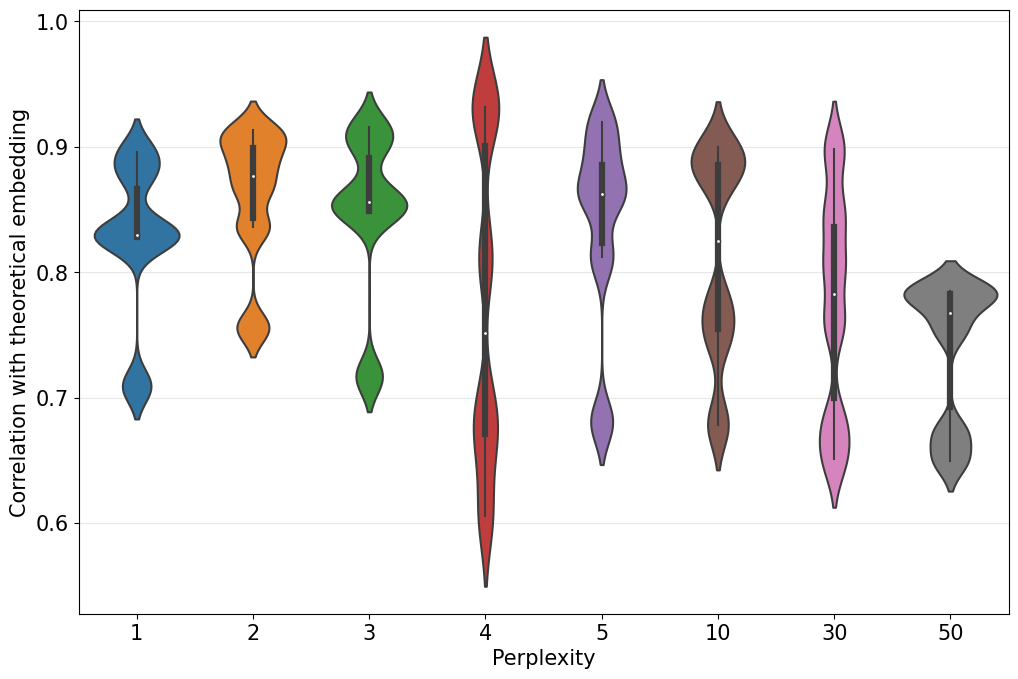

In [91]:
x = np.zeros((8, 6))
for p in range(len(p_vals)):
    x[p,:] = [corrs[i][p_vals[p]] for i in range(6)]

plt.figure(figsize=(12, 8))
sns.violinplot(data=x.T, bw=0.2)
plt.xticks(np.arange(len(p_vals)), p_vals)
plt.xlabel("Perplexity")
plt.ylabel("Correlation with theoretical embedding")
plt.savefig("perplexity.pdf")
plt.show()

kappa = 1, responses = 25, K = 20


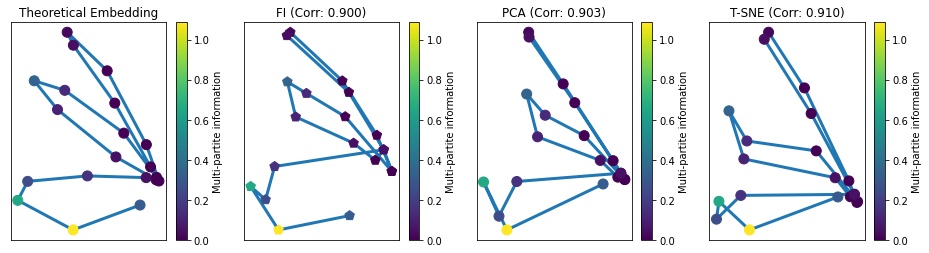

kappa = 2, responses = 25, K = 20


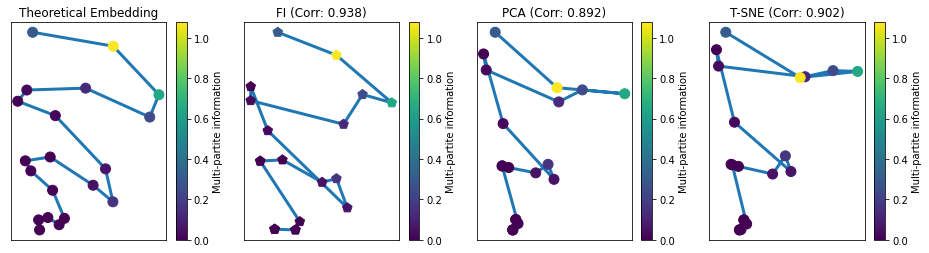

kappa = 6560, responses = 25, K = 20


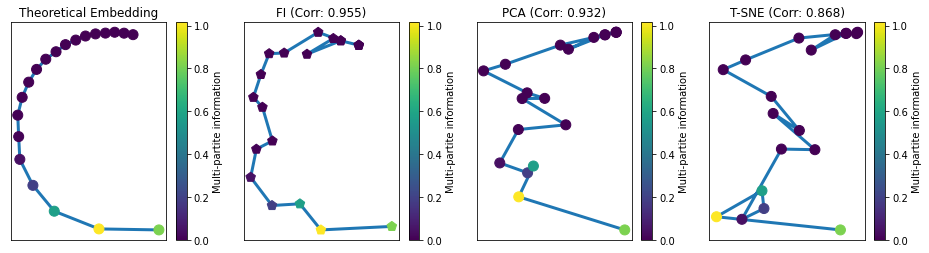

kappa = 1, responses = 50, K = 50


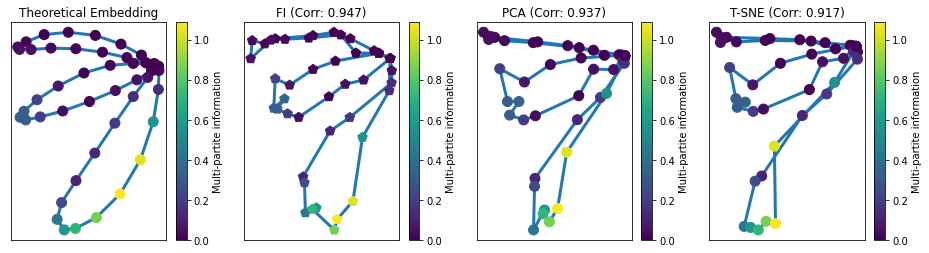

kappa = 2, responses = 50, K = 50


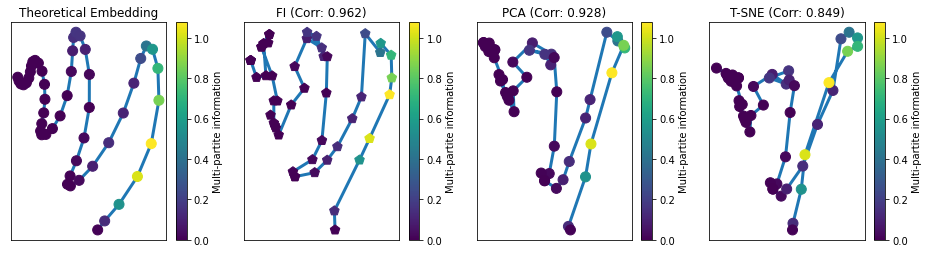

kappa = 6560, responses = 50, K = 50


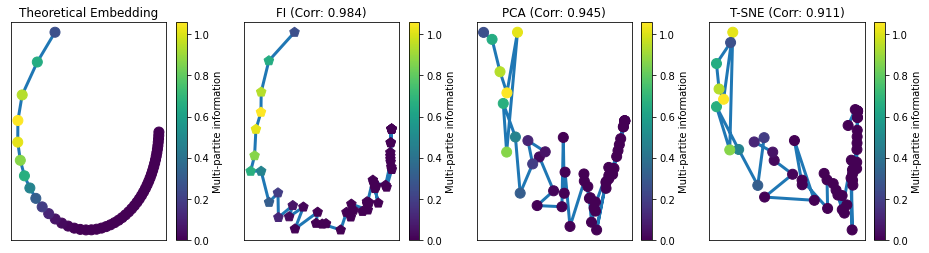

In [6]:
# correlations are non-deterministic, depends on the run (some randomness involved)
for i in range(6):
    print(f"kappa = {kappa[i]}, responses = {num_responses[i]}, K = {num_samples[i]}")
    comparison_plot(kappa=kappa[i], m=3, samples=num_samples[i], responses=num_responses[i],
                    number_q=number_q, number_a=number_a)

kappa = 1, responses = 25, K = 20


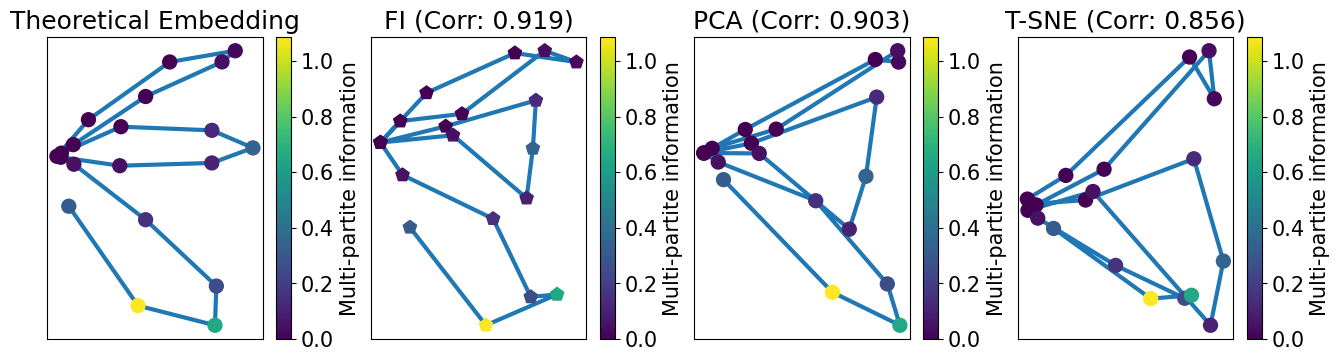

kappa = 2, responses = 25, K = 20


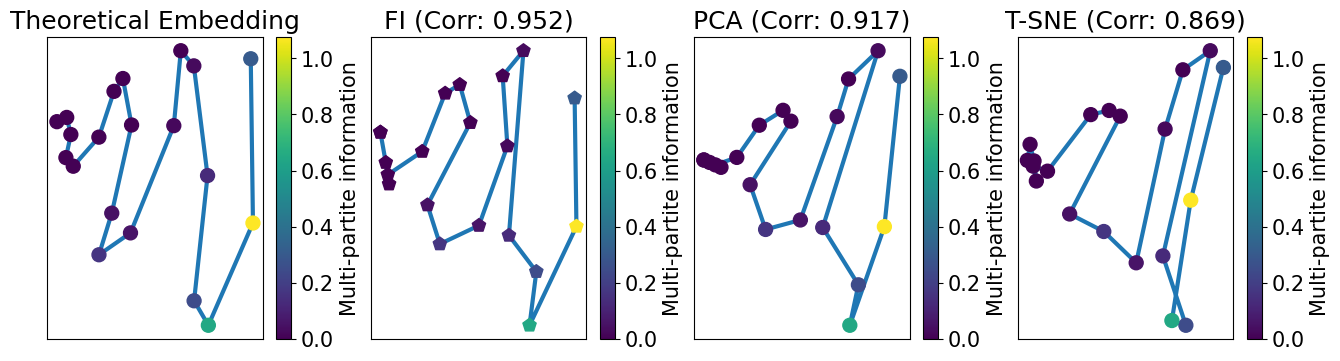

kappa = 6560, responses = 25, K = 20


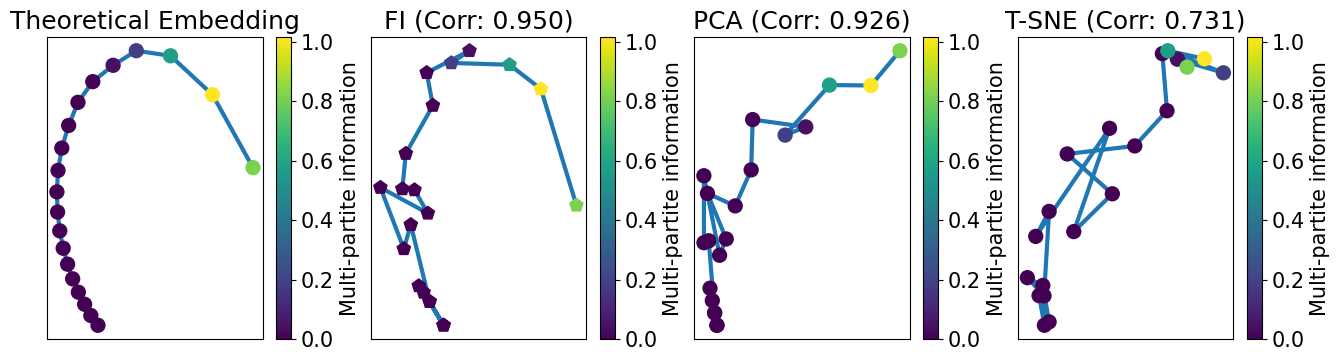

kappa = 1, responses = 50, K = 50


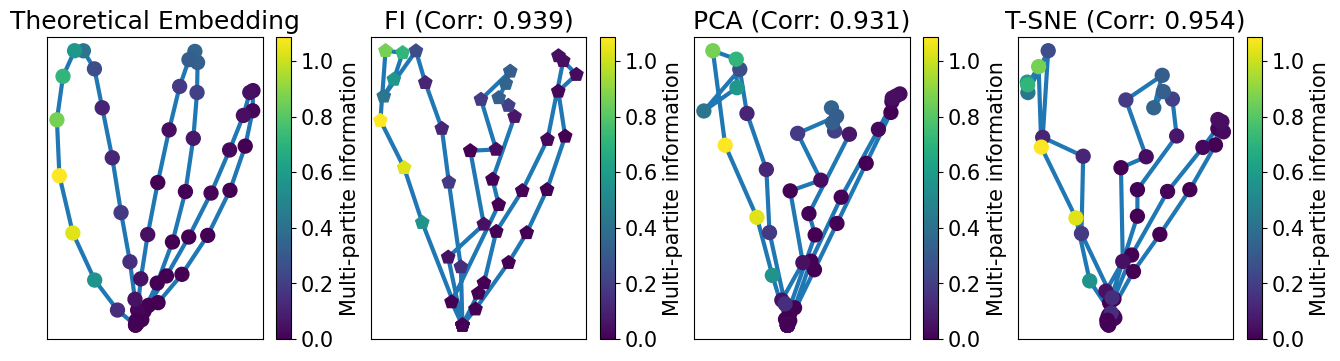

kappa = 2, responses = 50, K = 50


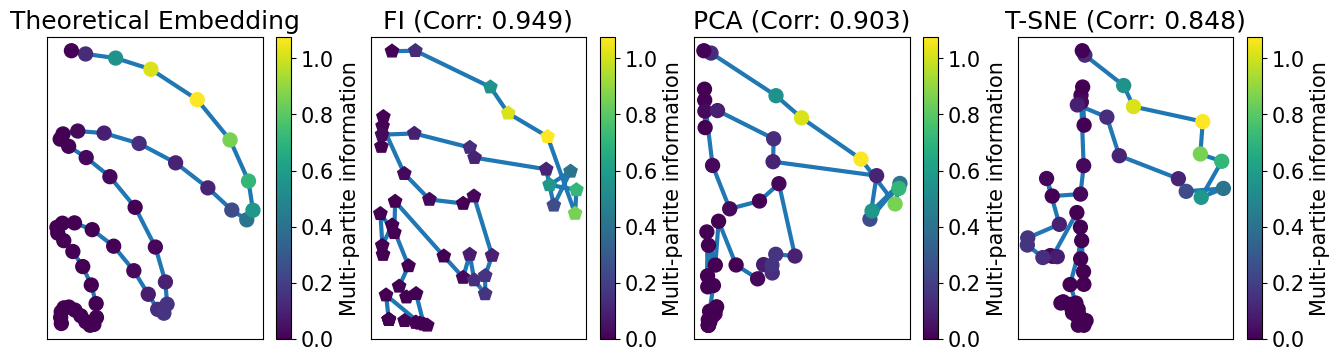

kappa = 6560, responses = 50, K = 50


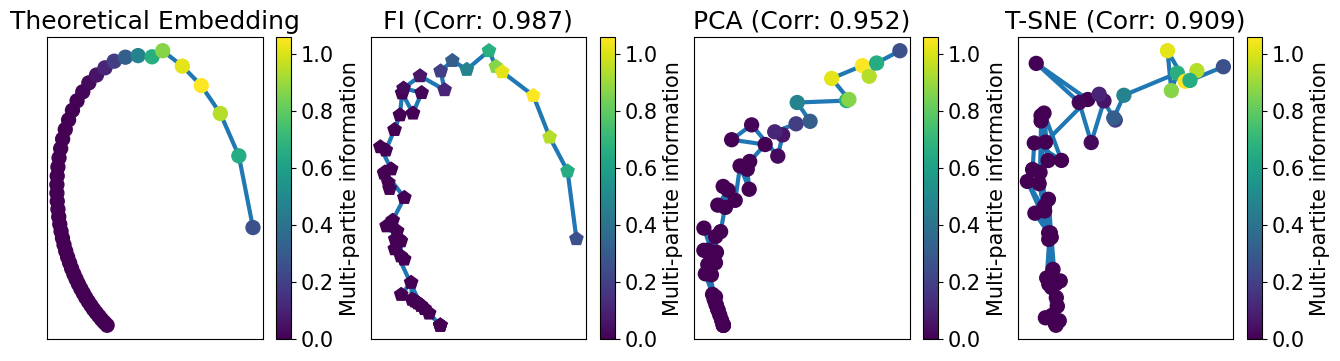

In [92]:
# correlations are non-deterministic, depends on the run (some randomness involved)
for i in range(6):
    print(f"kappa = {kappa[i]}, responses = {num_responses[i]}, K = {num_samples[i]}")
    comparison_plot(kappa=kappa[i], m=3, samples=num_samples[i], responses=num_responses[i],
                    number_q=number_q, number_a=number_a)

In [11]:
dim = 2
m = 3
number_q = 8
number_a = 3
N = number_a**number_q
kappas = [2, N-1]
num_samples   = 20
num_responses = 25

p_vals = [1, 2, 3, 4]

results = {}

for k in kappas:
    
    results[k] = {p:[] for p in p_vals}
    
    for iteration in range(5):
        probs = get_curve_samples(number_q=number_q, number_a=number_a, 
                              samples=num_samples, m=m, sin_angle=k-1)
        df = get_questionnaires(probs, count_answers=num_responses, number_q=number_q, number_a=number_a)
        true_mds = get_true_mds(probs)
        df.name_1 = df.name_1.astype(int)

        for p in p_vals:
            tsne = tsne_alg(df, df.columns.drop("name_1"), dim=dim, perplexity=p)
            tsne = align_pca_mds(true_mds, tsne)
            tsne_corr = corr_between_coords(true_mds, tsne)
            results[k][p].append(tsne_corr)

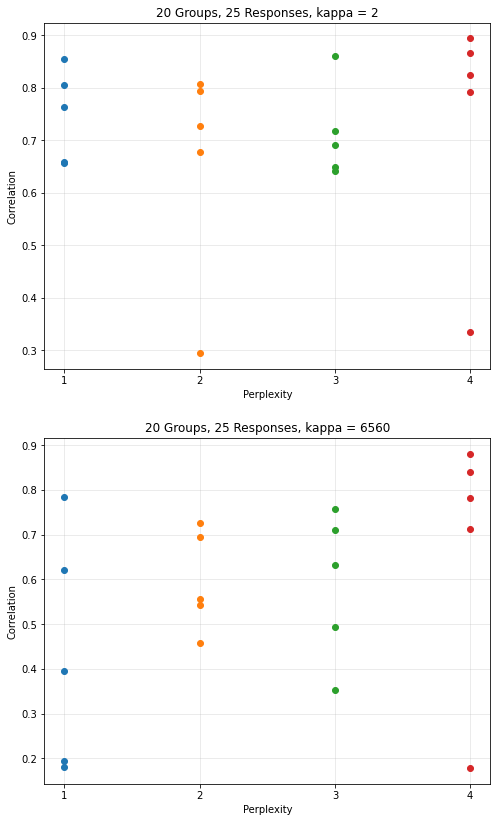

In [12]:
# learning rate 200, pca init
plt.figure(figsize=(8, 14))
for k in kappas:
    if k == 2:
        plt.subplot(211)
    else:
        plt.subplot(212)
    for i, p in enumerate(p_vals):
        plt.scatter([i]*5, results[k][p])
        plt.xticks(np.arange(4), p_vals)
    plt.xlabel("Perplexity")
    plt.ylabel("Correlation")
    plt.title(f"20 Groups, 25 Responses, kappa = {k}")

plt.savefig("second_third_embeddings.pdf")
plt.show()

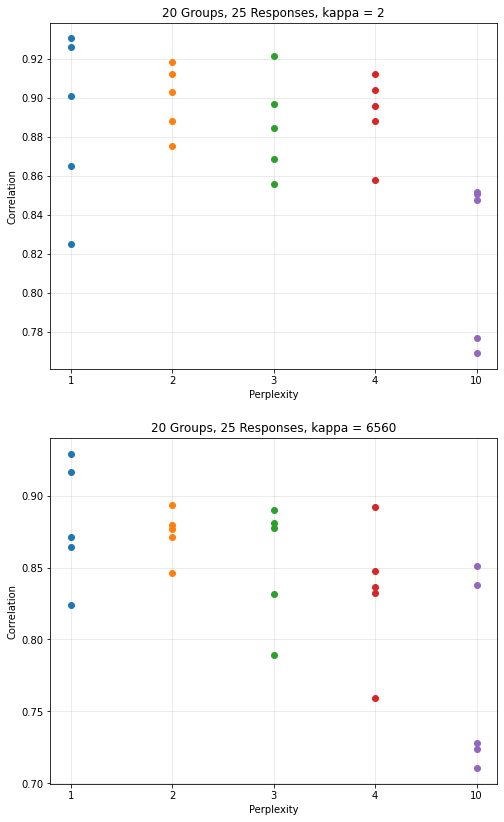

In [7]:
# learning rate 20, pca init
plt.figure(figsize=(8, 14))
for k in kappas:
    if k == 2:
        plt.subplot(211)
    else:
        plt.subplot(212)
    for i, p in enumerate(p_vals):
        plt.scatter([i]*5, results[k][p])
        plt.xticks(np.arange(4), p_vals)
    plt.xlabel("Perplexity")
    plt.ylabel("Correlation")
    plt.title(f"20 Groups, 25 Responses, kappa = {k}")

plt.savefig("second_third_embeddings.pdf")
plt.show()

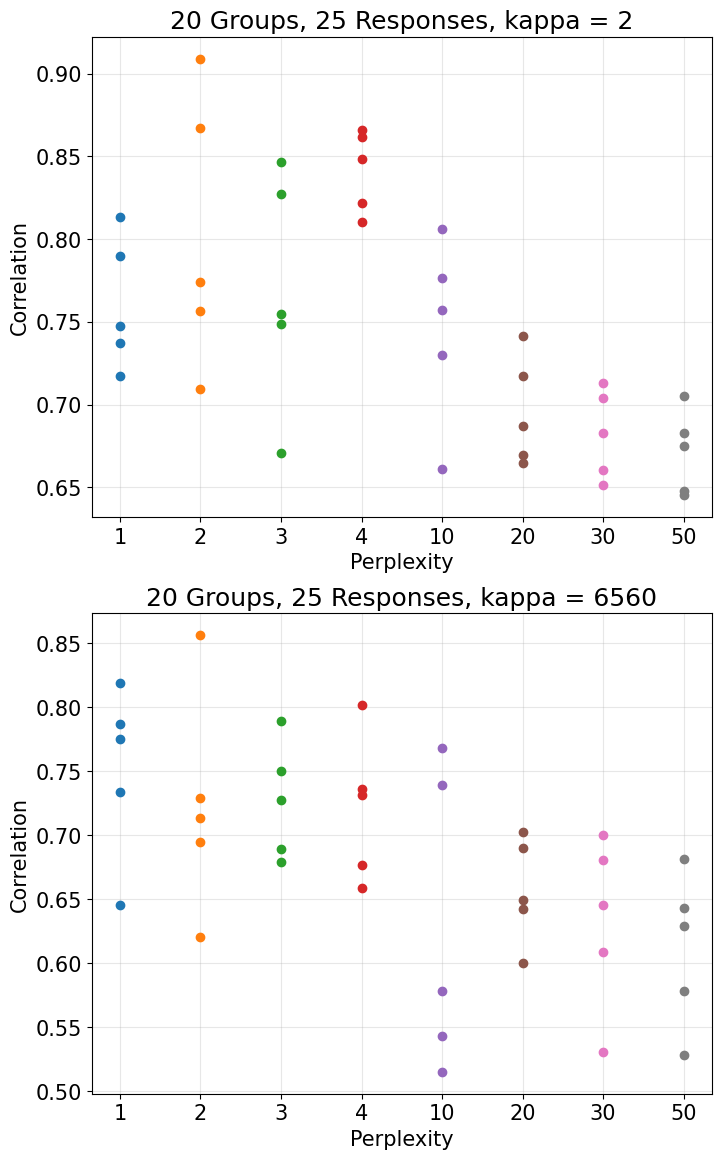

In [115]:
# learning rate 200, random init
plt.figure(figsize=(8, 14))
for k in kappas:
    if k == 2:
        plt.subplot(211)
    else:
        plt.subplot(212)
    for i, p in enumerate(p_vals):
        plt.scatter([i]*5, results[k][p])
        plt.xticks(np.arange(8), p_vals)
    plt.xlabel("Perplexity")
    plt.ylabel("Correlation")
    plt.title(f"20 Groups, 25 Responses, kappa = {k}")

plt.savefig("second_third_embeddings.pdf")
plt.show()

### Plot results from LISA

In [34]:
# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(distance_mat, n, eps, t, n_eigen, alpha=1/2):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """    
    
#     # Finding the distance matrix"
#     covariance_matrix = data_matrix@data_matrix.T

#     distance_mat_1 = -2*covariance_matrix
#     distance_mat_2 = np.outer(np.diag(covariance_matrix), np.ones((n, 1))) + np.outer(np.ones((n, 1)), np.diag(covariance_matrix).T)
#     distance_mat = distance_mat_1+distance_mat_2

    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = np.linalg.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(alpha)@M@np.linalg.inv(D)**(alpha)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = np.linalg.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = np.linalg.inv(D)**(alpha)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

In [52]:
def weighted_hamming(X):
    # compute number of categories per feature
    pi_k = np.zeros(len(X.columns))
    for i, col in enumerate(X.columns):
        pi_k[i] = len(X[col].unique())
    pi_k = 1/pi_k

    X = np.array(X)

    H = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            hamming = np.sum(np.array(X[i] != X[j]) * pi_k)
            H[i][j] = hamming
            H[j][i] = hamming
            
    return H

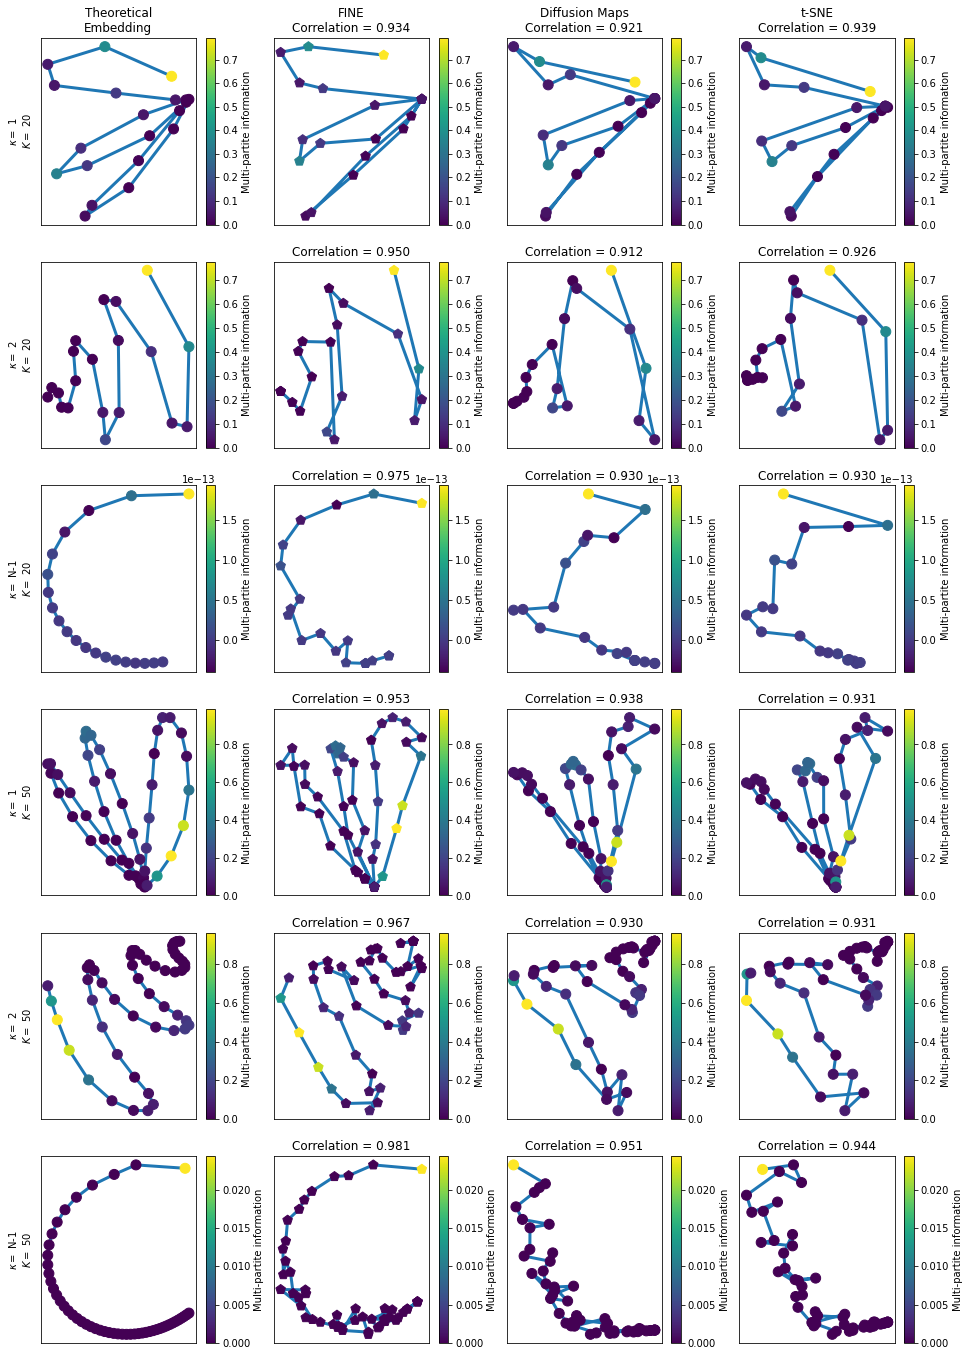

In [61]:
plt.figure(figsize=(16,24))

dim = 2

for i in range(6):
    
    with open(f"../LISA/tsne_embedding/results/{i}.pickle", "rb") as f:
        data = pickle.load(f)
        
    KLs = data["KLs"]
    df = data["df"]
        
    # theoretical embedding
    true_mds = data["true_coords"]
    
    plt.subplot(6, 4, 4*i+1)
    plt.scatter(true_mds[:,0], true_mds[:,1], marker='o', label="True FI", c=KLs, s=100, zorder=3)
    plt.plot(true_mds[:,0], true_mds[:,1], label="True FI", lw=3, zorder=2)
    if i == 0:
        plt.title("Theoretical\nEmbedding")
    plt.xticks([])
    plt.yticks([])
    if i in [0, 3]:
        kappa = "1"
    elif i in [1, 4]:
        kappa = "2"
    else:
        kappa = "N-1"
    if i < 3:
        K = "20"
    else:
        K = "50"
    plt.ylabel(r"$\kappa = $ " + kappa + "\n" + r"$K = $ " + K)
    plt.colorbar(label="Multi-partite information")
    
    # Fisher information
    _, mds_joint = compute_mds(df, dim=dim, compute_joint=True)
    mds_joint = align_pca_mds(true_mds, mds_joint)
    fi_corr = corr_between_coords(true_mds, mds_joint)
    
    plt.subplot(6, 4, 4*i+2)
    plt.scatter(mds_joint[:,0], mds_joint[:,1], marker='p', label="FI Joint", c=KLs, s=100, zorder=3)
    plt.plot(mds_joint[:,0], mds_joint[:,1],  label="FI Joint", lw=3, zorder=2)
    if i == 0:
        plt.title("FINE\nCorrelation = %.3f" % fi_corr)
    else:
         plt.title("Correlation = %.3f" % fi_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    # PCA
#     df.name_1 = df.name_1.astype(int)
#     pca, _ = get_pca(df, df.columns.drop("name_1"), dim=dim, align=False)
#     pca = align_pca_mds(true_mds, pca)
#     pca_corr = corr_between_coords(true_mds, pca)
    
    
    # Diffusion maps
    df.name_1 = df.name_1.astype(int)
    subaks = sorted(df.name_1.unique())
    X = weighted_hamming(df.loc[:, df.columns!="name_1"])
    dm = np.real(diffusionmap(X, len(df), eps=1, t=0.5, n_eigen=dim))
    dm_coords = np.zeros(shape=(len(subaks), dim))
    for k, s in enumerate(subaks):
        ind = df[df.name_1 == s].index
        dm_coords[k,:] = np.mean(dm[ind], axis=0)
    dm = align_pca_mds(true_mds, dm_coords)
    dm_corr = corr_between_coords(true_mds, dm)
    
#     df.name_1 = df.name_1.astype(int)
#     subaks = sorted(df.name_1.unique())
#     dm = np.real(diffusionmap(np.array(df.loc[:, df.columns!="name_1"]), len(df), 5, 0, n_eigen=dim))
#     dm_coords = np.zeros(shape=(len(subaks), dim))
#     for k, s in enumerate(subaks):
#         ind = df[df.name_1 == s].index
#         dm_coords[k,:] = np.mean(dm[ind], axis=0)

#     dm = align_pca_mds(true_mds, dm_coords)
#     dm_corr = corr_between_coords(true_mds, dm)
    
    plt.subplot(6, 4, 4*i+3)
    plt.scatter(dm[:,0], dm[:,1], label="Diffusion Maps", c=KLs, s=100, zorder=3)
    plt.plot(dm[:,0], dm[:,1],  label="PCA", lw=3, zorder=2)
    if i == 0:
        plt.title("Diffusion Maps\nCorrelation = %.3f" % dm_corr)
    else:
        plt.title("Correlation = %.3f" % dm_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")

    # T-SNE
    plt.subplot(6, 4, 4*i+4)
    tsne = data["tsne_coords"]
    tsne_corr = data["corr"]
    
    plt.scatter(tsne[:,0], tsne[:,1], label="t-SNE", c=KLs, s=100, zorder=3)
    plt.plot(tsne[:,0], tsne[:,1],  label="t-SNE", lw=3, zorder=2)
    if i == 0:
        plt.title("t-SNE\nCorrelation = %.3f" % tsne_corr)
    else:
        plt.title("Correlation = %.3f" % tsne_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")

#plt.savefig("latest_embedding_comparison.pdf")
plt.show()